<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/master/03-Deep-Learning/notebooks/Tarea-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

print('GPU presente en: {}'.format(tf.test.gpu_device_name()))

GPU presente en: /device:GPU:0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

# Tarea 2: X-rays
































Este conjunto de entrenamiento consta de 5886 imágenes de rayos X de torax divididas en dos clases: Pneumonia y Normal.

Estas imágenes de radiografía de tórax son de pacientes pediátricos de uno a cinco años del Centro Médico de Mujeres y Niños de Guangzhou, Guangzhou. Todas las radiografías de tórax se realizaron como parte de la atención clínica rutinaria de los pacientes.

Para el análisis de las imágenes, se sometieron inicialmente a un control de calidad mediante la eliminación de todas las exploraciones de baja calidad o ilegibles. A continuación, los diagnósticos de las imágenes fueron calificados por dos médicos expertos antes de ser autorizados para el entrenamiento del sistema de IA. Para tener en cuenta cualquier error de clasificación, el conjunto de evaluación también fue revisado por un tercer experto.

Este conjunto de datos se puede encontrar en [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia).

La copia con la que trabajaremos se puede bajar de Google Drive: https://drive.google.com/file/d/1jbkvQB4L5y3UKkPurNp6nJonSoYbcYbI/view?usp=sharing

In [3]:
!pip install -q gdown

In [4]:
!gdown 1jbkvQB4L5y3UKkPurNp6nJonSoYbcYbI

Downloading...
From: https://drive.google.com/uc?id=1jbkvQB4L5y3UKkPurNp6nJonSoYbcYbI
To: /content/x-rays.zip
100% 1.24G/1.24G [00:08<00:00, 152MB/s]


Extraemos los archivos

In [5]:
from zipfile import ZipFile

fname = '/content/x-rays.zip'

with ZipFile(fname, 'r') as myzip:
    myzip.extractall()
    print('Listo')

Listo


Definimos las rutas de los archivos

In [6]:
train_dir = 'x-rays/train'
validation_dir = 'x-rays/val'
test_dir = 'x-rays/test'

Graficamos algunas instancias de cada clase

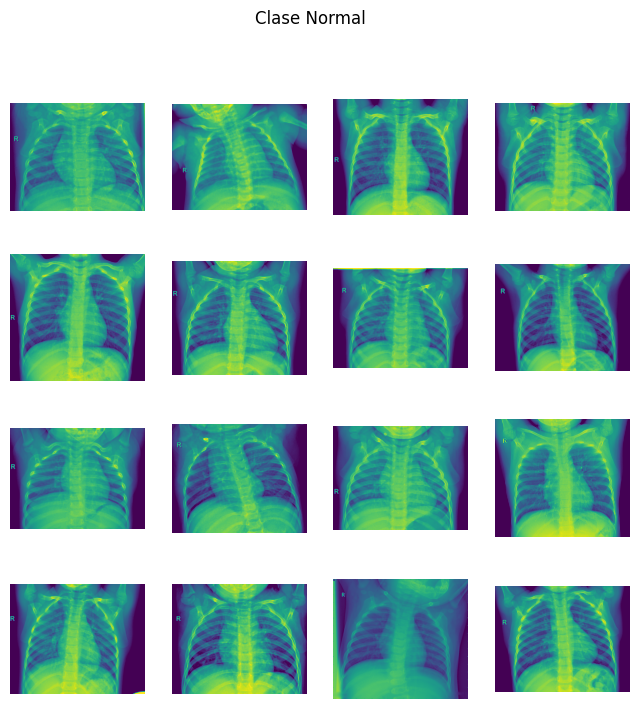

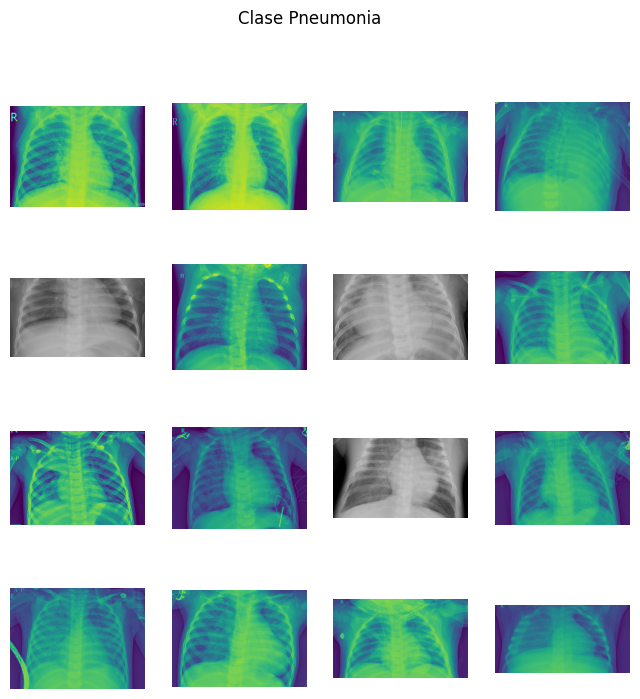

In [7]:
import pathlib
import PIL
import matplotlib.pyplot as plt

train_path = pathlib.Path(train_dir)

normal_vis = list(train_path.glob("NORMAL/*.jpeg"))

plt.figure(figsize = (8,8))
plt.suptitle("Clase Normal")
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = PIL.Image.open(str(normal_vis[i]))
    plt.imshow(img)
    plt.axis(False)
plt.show()

pneumonia_vis = list(train_path.glob("PNEUMONIA/*.jpeg"))

plt.figure(figsize = (8,8))
plt.suptitle("Clase Pneumonia")
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = PIL.Image.open(str(pneumonia_vis[i]))
    plt.imshow(img)
    plt.axis(False)
plt.show()

In [8]:
import os, shutil

print('Para entrenamiento:')
train_normal = os.path.join(train_dir,'NORMAL')
print(f"{len(os.listdir(train_normal))} Normal.")
train_pneumonia = os.path.join(train_dir,'PNEUMONIA')
print(f"{len(os.listdir(train_pneumonia))} Pneumonia.")

print('\nPara validación:')
validation_normal = os.path.join(validation_dir,'NORMAL')
print(f"{len(os.listdir(validation_normal))} Normal.")
validation_pneumonia = os.path.join(validation_dir,'PNEUMONIA')
print(f"{len(os.listdir(validation_pneumonia))} Pneumonia.")

print('\nPara prueba:')
test_normal = os.path.join(test_dir,'NORMAL')
print(f"{len(os.listdir(test_normal))} Normal.")
test_pneumonia = os.path.join(test_dir,'PNEUMONIA')
print(f"{len(os.listdir(test_pneumonia))} Pneumonia.")

Para entrenamiento:
1341 Normal.
3875 Pneumonia.

Para validación:
8 Normal.
8 Pneumonia.

Para prueba:
234 Normal.
390 Pneumonia.


Por si queremos las imágenes en escala de grises

In [30]:
import tensorflow as tf

def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

In [36]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False, # randomly flip images
        # preprocessing_function=to_grayscale_then_rgb
        )

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(256,256),
        batch_size=32, # <-------- Este número lo usarás en la siguiente celda
        class_mode='binary')


Found 5216 images belonging to 2 classes.


In [37]:
from keras.preprocessing.image import ImageDataGenerator

val_datagen = ImageDataGenerator(rescale=1./255,
                                #  preprocessing_function=to_grayscale_then_rgb
                                 )
test_datagen = ImageDataGenerator(rescale=1./255,
                                #   preprocessing_function=to_grayscale_then_rgb
                                  )

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(256,256),
        batch_size=8, # <-------- Este número lo usarás en la siguiente celda
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(256,256),
        batch_size=16,
        class_mode='binary')

Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


⭕ ¿Cuántos lotes hay que pasar para recorrer todo el conjunto de entrenamiento por cada época? ¿cuántos para recorrer todo el conjunto de validación?

In [11]:
steps_per_epoch = 5216/32 # calcula este número
steps_per_epoch = int(steps_per_epoch)
validation_steps = 16/8 # calcula este número
validation_steps = int(validation_steps)

print(f"Número de lotes para recorrer el conjunto de entrenamiento: {steps_per_epoch}")
print(f"Número de lotes para recorrer el conjunto de validación: {validation_steps}")

Número de lotes para recorrer el conjunto de entrenamiento: 163
Número de lotes para recorrer el conjunto de validación: 2


##  El modelo

⭕ Define un módelo de red neuronal CNN para la tarea de clasificación binaria de este conjunto de datos. Puedes usar dropout, el número de capas, épocas y activaciones que consideres necesario.

Al final, reporta las métrica Accuracy.

In [38]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.optimizers import RMSprop

model = Sequential([
    Conv2D(16, 3, activation='relu',
                           input_shape=(256,256, 3)),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Otra posible arquitectura

In [33]:
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, MaxPool2D, BatchNormalization, Dropout

# model = Sequential()
# model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (256,256,3)))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Flatten())
# model.add(Dense(units = 128 , activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(Dense(units = 1 , activation = 'sigmoid'))

# model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

# model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 batch_normalization_20 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 dropout_16 (Dropout)        (None, 128, 128, 64)      0         
                                                                 
 batch_normalization_21 (Bat  (None, 128, 128, 64)    

⭕ Define un callback `EarlyStopping` llamado `e_stopping` para detener el entrenamiento si comienza el overfitting. Puedes experimentar con el hiper-parámetro `patience`

In [39]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

e_stopping = EarlyStopping(monitor='val_loss',patience=2)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Realiza el entrenamiento del modelo. Es tardado el entrenamiento.

In [40]:
num_epocas = 100

history = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=num_epocas,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      callbacks=[e_stopping,learning_rate_reduction])

Epoch 1/100
163/163 [==============================] - 128s 776ms/step - loss: 0.6121 - accuracy: 0.7322 - val_loss: 0.6735 - val_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 2/100
163/163 [==============================] - 126s 774ms/step - loss: 0.4923 - accuracy: 0.7688 - val_loss: 0.7141 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 3/100
163/163 [==============================] - 123s 757ms/step - loss: 0.4294 - accuracy: 0.7987 - val_loss: 0.5741 - val_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 4/100
163/163 [==============================] - 124s 762ms/step - loss: 0.3833 - accuracy: 0.8273 - val_loss: 0.5892 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 5/100
163/163 [==============================] - 123s 752ms/step - loss: 0.3493 - accuracy: 0.8480 - val_loss: 0.6516 - val_accuracy: 0.6875 - lr: 1.0000e-04


Evalua el desempeño de tu modelo usando el conjunto de entrenamiento.

In [41]:
score = model.evaluate(test_generator)
print ('Test loss:', round(score[0], 3))
print ('Test accuracy:', round(score[1]*100, 2))

39/39 [==============================] - 6s 151ms/step - loss: 0.3612 - accuracy: 0.8333
Test loss: 0.361
Test accuracy: 83.33


⭕ Grafica las curvas de entrenamiento de loss y accuracy

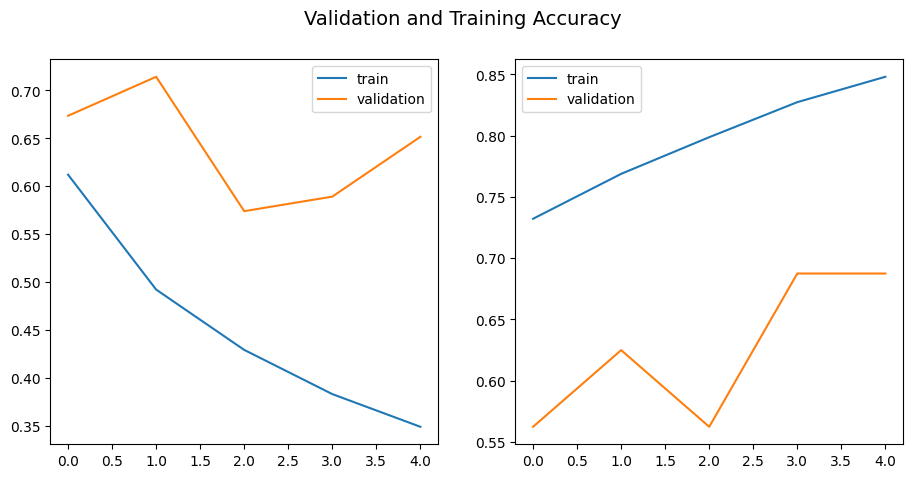

In [42]:
import matplotlib.pyplot as plt

# ---- graficamos la función de perdida ----
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
# ---- graficamos la métrica de rendimiento ----
plt.subplot(1,2,2)
plt.suptitle("Validation and Training Accuracy",fontsize=14)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()